# Style Transfer


## Overview

The world has seen so many great painters / paintings. Have you ever wondered if you could bring style or pattern of a particular painting to your own work and see how they blend. Sounds fun isn't it ? This is called  **Style Transfer** . Well , Deep Neural Networks (DNNs) have already baffled us with their abilities in the most complicated fields like healthcare , game-playing , computer-vision etc. And no wonder deep-learning also offers a wonderful way of achieving the style transfer. This mini-tutorial assumes that the basics of DNNs are known and hence would be focussing on the exact methodlogy of **Neural Style Transfer**   

## Description

- What is Neural Style Transfer?
- Dependencies and imports
- Preprocessing of data 
- Losses 
- User Inputs
- Building the model
- Extracting features and calculation of losses (Content loss , Style loss , Gram natrix and Total Variance loss)
- Evaluation of the model (loss and gradients)
- Optimising loss functions and Results
- Applications
- References


## Pre-requisite

- Python (along with NumPy library)
- Keras (basic know-how)


## Learning Outcomes

- Style Transfer basic concepts and losses
- Creating your own style transfer model   

## Chapter 1: What is Neural Style Transfer ?

### Description: In this chapter you will be given the basic understanding of style-transfer and shown some areas of application for the Style Transfer Networks . 

Style transfer is the way of recreating the images in the style of other images. This concept was first discussed in a paper from Gatys et al. [https://arxiv.org/abs/1508.06576] which explains how to transfer artistic style from one painting to another using Convolution Neural Networks (CNNs). 

It can be treated as an optimization technique used to take a input image , content image and a style reference image (such as famous paintings), and blend them such that , input image looks like content image and “painted” in the style of the style image. Please note that , here we initialise the input image itself as content image. 

Neural style transfer defines two Loss (distance) functions :
1. **Content Loss** that describes how different the content of two images are.
2. **Style Loss** that describes the difference between the two images in terms of their style
3. **Total Variance Loss** that helps to reduce the noise in the generated image

Then, given 3 images, a desired style image, a desired content image, and the input image (initialized with the content image), the input image is transformed so as to minimize the content loss with the content image and its style loss with the style image

## Dependencies and  Imports
* python 3.x
* numpy
* scipy
* tensorflow (>= 1.10) with keras installed
Also the versions used in this tutorial are printed below

In [30]:
import time
import numpy as np
import scipy as sp
import tensorflow
import tensorflow.contrib.keras.api.keras.backend as K
from scipy.misc import imsave, imresize
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.contrib.keras.api.keras.applications import vgg19
from tensorflow.contrib.keras.api.keras.preprocessing.image import load_img, img_to_array
import keras 
import warnings
warnings.filterwarnings('ignore')

print("Versions : ")
print("numpy = " , np.__version__)
print("scipy = " , sp.__version__)
print("tensorflow = " , tensorflow.__version__)
print("Keras = " , keras.__version__)

Versions : 
numpy =  1.14.5
scipy =  1.1.0
tensorflow =  1.12.0
Keras =  2.2.4


## Data Preprocessing

Since we are using the pretrained VGG-19 model , we will be using the preprocessing it provides by default for accurate results.

Please note that for deprocessing the output , we use VGG_MEAN = [103.939, 116.779, 123.68] which is the standard according to the paper. 

More info about the calculation these values can be found at :  https://forums.fast.ai/t/how-is-vgg16-mean-calculated/4577/2 

In [31]:
def preprocess(img_path , h , w ):
    # Preprocessing to make the style transfer
    # possible
    img = load_img(img_path)
    img = img_to_array(img)
    # This dimensions are for Tensorflow backend
    img = imresize(img, (h, w, 3))
    img = img.astype('float64')
    # Add the batch dimension
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img 


def deprocess_image(img , h, w):
    if K.image_data_format() == 'channels_first':
        # For Theano
        img = img.reshape((3, h, w))
        img = img.transpose((1, 2, 0))
    else:
        img = img.reshape((h, w, 3))
    # Remove zero-center by mean pixel
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

## Losses

## Content Loss

We can construct images whose feature maps at a chosen convolution layer match the corresponding feature maps of a given content image. The 2 images can have the same content — but need not have same texture and style.

Given a chosen content layer l, the content loss is defined as the Mean Squared Error (Euclidean distance) between the feature map F of our content image C and the feature map P of our generated image Y.
The content loss gives the distance between outputs of the model for the content image and the generated image at a specific layer in the network. The outputs here are the feature-maps since they are tapped from intermediate convolution layers.

<img src="https://raw.githubusercontent.com/Amit12690/StyleTransfer/master/images/tutorial_images/L_content.png" alt="content_loss" width="250px"/>

Minimum content loss , means that the feature activations in the given layers of the blended output image  are very similar to those in content-image. The kinds of features that are transferred from content image to the blended output image is dependent on the layers we choose


In [32]:
def content_loss(content, gen):
    
    """ content -->  feature map of the content image
        gen     -->  feature map of the generated image  """
    
    assert K.ndim(content) == 3
    assert K.ndim(gen) == 3
    # Euclidean distance
    return K.sum(K.square(gen - content))

## Style Loss and Gram Matrix

For style-layers,  we need to measure which features in the style-layers activate simultaneously for the style-image, and then copy this activation-pattern to the mixed-image.

How do we do this ? 

The **Gram-matrix** comes to our help . The Gram-matrix is essentially just a matrix of dot-products for the vectors of the feature activations of a style-layer. Gram matrix is the dot product of the flattened feature map and the transpose of the flattened feature map.

If an entry in the Gram-matrix has a value close to zero then it means the two features in the given layer do not activate simultaneously for the given style-image. And vice versa, if an entry in the Gram-matrix has a large value, then it means the two features do activate simultaneously for the given style-image. We will then try and create a blend-image that replicates this activation pattern of the style-image.


<img src="https://raw.githubusercontent.com/Amit12690/StyleTransfer/master/images/tutorial_images/Gram_matrix.png" alt="Gram_matrix" width="200px"/>


The loss function for style is quite similar to out content loss, except that we calculate the Mean Squared Error for the Gram-matrices instead of the raw tensor-outputs from the layers.

<img src="https://raw.githubusercontent.com/Amit12690/StyleTransfer/master/images/tutorial_images/Style_loss.png" alt="Style_loss" width="250px"/>

If we had two images whose feature maps at a given layer produced the same Gram matrix we would expect both images to have the same style, but not necessarily the same content. 

Applying this to early layers in the network would capture some of the finer textures contained within the image whereas applying this to deeper layers would capture more higher-level elements of the image’s style. Gatys et. al found that the best results were achieved by taking a combination of shallow and deep layers as the style representation for an image.


In [33]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # Dot product of the flattened feature map and the transpose of the
    # flattened feature map
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, gen):
    assert K.ndim(style) == 3
    assert K.ndim(gen) == 3
    S = gram_matrix(style)
    G = gram_matrix(gen)
    channels = 3
    size = img_h * img_w
    # Euclidean distance of the gram matrices multiplied by the constant
    return K.sum(K.square(S - G)) / (4. * (channels ** 2) * (size ** 2))

## Total Variation Loss (TV Loss)

We also need to add a third type of loss, the total variance loss.

This loss reduces the amount of noise in the generated image. This means that the generated image will not look all fuzzy, but rather it will look smooth and overall better.

We just go over the image pixel by pixel and see how big of a distance there is between them.

In [34]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(x[:, :, :img_h - 1, :img_w - 1] - x[:, :, 1:, :img_w - 1])
        b = K.square(x[:, :, :img_h - 1, :img_w - 1] - x[:, :, :img_h - 1, 1:])
    else:
        # Move the image pixel by pixel, and calculate the variance
        a = K.square(x[:, :img_h - 1, :img_w - 1, :] - x[:, 1:, :img_w - 1, :])
        b = K.square(x[:, :img_h - 1, :img_w - 1, :] - x[:, :img_h - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

## USER INPUTS

max_iter : I have used 200 for faster results . More the iterations , smoother the output will be 

CONTENT_WEIGHT : I have used 0.7 . This can be adjusted to control the amount of content image to be retained in the output. 

STYLE_WEIGHT = 1.0  : Controls the amount of style content in the image 

TV_WEIGHT = 1.0  : Noise removal and smoothing effect control 

img_h = 600 : Output image dimensions control 

In [35]:
# Define constants
CONTENT_IMG_PATH = '../data/content_input_images/monalisa.jpg'
STYLE_IMG_PATH = '../data/style_images/style1.jpg'

orig_img = img_to_array(load_img(CONTENT_IMG_PATH))
orig_style_img = img_to_array(load_img(STYLE_IMG_PATH))

# Number of optimisation iterations to run 
max_iter = 800

# Weights of losses
CONTENT_WEIGHT = 0.7 #0.01
STYLE_WEIGHT = 1.0 #1.0
TV_WEIGHT = 1.0

# Define the shape of the output image
h, w = load_img(CONTENT_IMG_PATH).size
img_h = 600 #400
img_w = int(h * img_h / w)


# Create Keras variables of input images
content_img = K.variable(preprocess(CONTENT_IMG_PATH , img_h , img_w))
style_img  = K.variable(preprocess(STYLE_IMG_PATH, img_h , img_w))

if K.image_data_format() == 'channels_first':
    gen_img = K.placeholder(shape=(1, 3, img_h, img_w))
else:
    gen_img = K.placeholder(shape=(1, img_h, img_w, 3))

# Create a single tensor containing all three images
input_tensor = K.concatenate([content_img, style_img, gen_img], axis=0)


## Building the model 

In this case, we load VGG19, and feed in our input tensor to the model. This will allow us to extract the feature maps  of the content, style, and generated images.

We use VGG19, as suggested in the paper. In addition, since VGG19 is a relatively simple model (compared with ResNet, Inception, etc) the feature maps actually work better for style transfer. 

The vgg model is dowloaded by using the *vgg19.VGG19* modethod

In order to access the intermediate layers corresponding to our style and content feature maps, we get the corresponding outputs by using the Keras Functional API to define our model with the desired output activations.

With the Functional API, defining a model simply involves defining the input and output: model = Model(inputs, outputs).

Now we need to initialize the variables. Those are the content image, the style image and the generated image.

Note that we are loading the model and exclusing the fully connected layers in the end , since we only need the convolution features


In [36]:
# Create a vgg19 model by running the input tensor though the vgg19 convolutional
# neural network, excluding the fully connected layers
model = vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)
model.trainable = False
print('Model loaded')

# Create an output dictionary
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


Model loaded


In [37]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (3, 600, 396, 3)          0         
_________________________________________________________________
block1_conv1 (Conv2D)        (3, 600, 396, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (3, 600, 396, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (3, 300, 198, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (3, 300, 198, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (3, 300, 198, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (3, 150, 99, 128)         0         
__________

## Extracting features and calculation of losses 

Refer the VGG-19 network layers above. We are interested in tapping the features at the convolution blocks. 
There are 5 convolution blocks indicated by **block(i)_conv(j)**

You can see that we are using intermediate layers from VGG-19 model . How do these intermediate layers allow us to define style and content representations? 

This goes back to the basics of **Deep Neural Networks** especially CNNs. To perform tasks like image classification , it must understand the image. This means the network takes the raw image as input pixels and builds an internal representation using transformations/filters that turn the raw image pixels into a complex clusters of features.  

Thus, in between the layers of the trained model there are latent representations of the learnt data which behave as feature extractors on the input fed. Hence by accessing intermediate layers, we’re able to describe the content and style of input images.

The early layers of the network (block1 , block2 , block3) would capture some of the finer textures contained within the image 
The deeper layers (block4 , block5) would capture more higher-level elements of the image’s style. 

Gatys et. al found that the best results were achieved by taking a combination of shallow and deep layers as the style representation for an image.

The below image provides a sneak-peak in to the features at each layer 

<img src="https://raw.githubusercontent.com/Amit12690/StyleTransfer/master/images/tutorial_images/VGG_Feature_maps.jpg" alt="drawing" width="350px"/>

In [38]:
loss = 0.0
# For content loss, we're using the 2nd convolutional layer from the 5th block
layer_features = outputs_dict['block5_conv2']
content_img_features = layer_features[0, :, :, :]
gen_img_features = layer_features[2, :, :, :]
loss += CONTENT_WEIGHT * content_loss(content_img_features, gen_img_features)

# For style loss, we are using 1st convolutional layer from all 5 conv blocks 
feature_layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
for name in feature_layer_names:
    layer_features = outputs_dict[name]
    style_features = layer_features[1, :, :, :]
    gen_img_features = layer_features[2, :, :, :]
    s1 = style_loss(style_features, gen_img_features)
    # We need to devide the loss by the number of layers that we take into account
    loss += (STYLE_WEIGHT / len(feature_layer_names)) * s1
loss += TV_WEIGHT * total_variation_loss(gen_img)

# Calculate gradients
grads = K.gradients(loss, gen_img)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

# Define a Keras function to tap the grads and losses from the model
f_output = K.function([gen_img], outputs)


## Evaluation of loss and gradients

We will define a class which helps us access the loss and grad using the **f_output()** function defined above

Gradients are very easy to calculate. We just pass the generated image and the loss to the functionK.gradients().

We also need to define a Keras function which calculates the loss and the gradients during the optimization.

Also, a function which interprets that output and an evaluator object which keeps track of the loss and gradients would be nice as well.


In [39]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_h, img_w))
    else:
        x = x.reshape((1, img_h, img_w, 3))
    # Update the loss and the gradients
    outs = f_output([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_value = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_value = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grads_value = grad_value
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grads_values = np.copy(self.grads_value)
        self.loss_value = None
        self.grads_value = None
        return grads_values

# Optimising the Loss functions and Results

Using a pre-trained neural network such as VGG-19, an input image (i.e. an image which provides the content), a style image (a painting with strong style elements) and a random image (output image), one could minimize the losses in the network. 

The Evaluator() class defiend above provides methods to access loss and gradients. 
Now we have a computation graph ready . How do we optimize it ?
There are many optimisation techniques ranging from simplest (like gradient_descent) to most sophisticated ones (like ADAM) 

In this case, for ease of implementation we can use limited memory BFGS , from scipy.optimize package. It helps us optimise our loss functions. 

Some parameters defined in **User Inputs** section can be tuned for better outputs. Higher max_iter and different values for CONTENT_WEIGHT can help getting even better results


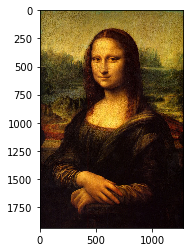

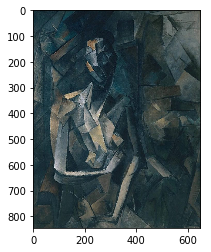

    loss: 140829856.0
     Image saved. Time: 239.00893187522888


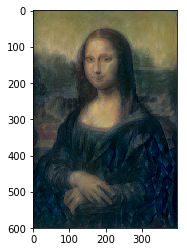

In [40]:
# import packages
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(orig_img.astype('uint8'))
plt.show()
plt.imshow(orig_style_img.astype('uint8'))
plt.show()

evaluator = Evaluator()

# Run L-BFGS optimizer
preprocessd_img = preprocess(CONTENT_IMG_PATH , img_h , img_w)

start_time = time.time()
x, min_val, info = fmin_l_bfgs_b(evaluator.loss, np.copy(preprocessd_img).flatten(), fprime=evaluator.grads,
                                 maxiter=max_iter)
print('    loss: {}'.format(min_val))
# Save img
out_img = deprocess_image(x , img_h , img_w)
out_imgpath = CONTENT_IMG_PATH.split('/')[-1].split('.')[0] + '_' + str(CONTENT_WEIGHT) + '.jpg'
imsave('../output/'+out_imgpath, out_img)
print('     Image saved. Time: {}'.format(time.time() - start_time))
plt.imshow(out_img)
plt.show()

## Applications 

Style transfer has wide ranging applications in the field of art , photography and movies . Apps like Prisma and Lucid intelligently leveraged it to be a hit among the social network apps. With many innovative image filters storming the Instagram , the applications for Style transfer will  only increase. 

Audio/Music style transfers have already made some progress and several more use cases pertaining to unique human tasks like the style of playing chess etc. are also being explored, using more generalized frameworks of style transfer.

## References 

* VGG 19 model: https://github.com/machrisaa/tensorflow-vgg/blob/master/vgg19_trainable.py
* Original paper "A Neural Algorithm of Artistic Style" by Gatys et al.: https://arxiv.org/abs/1508.06576
* Original work of Style Transfer's TensorFlow implementation is from Anish Athalye : https://github.com/anishathalye/neural-style

* Most concepts and diagrams were obtained from the below blogs :
    * https://markojerkic.com/style-transfer-keras/
    * https://medium.com/data-science-group-iitr/artistic-style-transfer-with-convolutional-neural-network-7ce2476039fd
    * https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398 
    * https://github.com/llSourcell/AI_Artist/
  
  Applications and cool apps : 
  
  * http://genekogan.com/works/style-transfer/
  * https://medium.com/data-science-group-iitr/artistic-style-transfer-with-convolutional-neural-network-7ce2476039fd
  
  
  
  Optimisation :
  BFGS : https://en.wikipedia.org/wiki/Limited-memory_BFGS
  
  